In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, \
    StratifiedKFold, GridSearchCV, ParameterGrid, train_test_split, \
    cross_validate
from sklearn.metrics import accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, \
    RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
import time as time

# Read Data + Initial X, y Split {-}

In [59]:
df = pd.read_csv("data/heart_2020_cleaned_v2.csv")

X = df[df.columns.difference(['Unnamed: 0', 'HeartDisease'])]
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 0
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Address Dataset Imbalance {-}

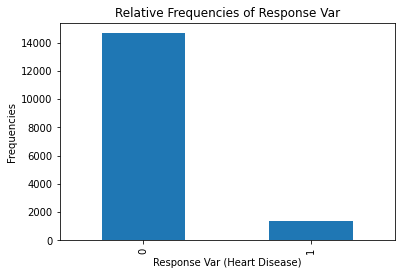

In [60]:
ax = y_train.value_counts().plot(
    kind = 'bar', title = 'Relative Frequencies of Response Var'
)
ax.set_xlabel('Response Var (Heart Disease)')
ax.set_ylabel('Frequencies')
plt.show()

In [61]:
rus = RandomUnderSampler(random_state = 1)
X_train, y_train = rus.fit_resample(X_train, y_train)

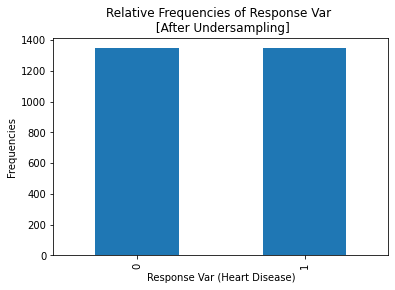

In [62]:
ax = y_train.value_counts().plot(
    kind = 'bar', 
    title = 'Relative Frequencies of Response Var \n [After Undersampling]'
)
ax.set_xlabel('Response Var (Heart Disease)')
ax.set_ylabel('Frequencies')
plt.show()

# AdaBoost {-}

In [109]:
def plot_metrics_against_cutoff(model, cutoffs = np.arange(0, 1.05, 0.05)):
    accuracies = []
    recalls = []
    
    for cutoff in cutoffs:
        acc, recall = eval_model(model, cutoff)
        accuracies.append(acc)
        recalls.append(recall)
        
    plt.plot(cutoffs, accuracies, marker = 'o', label = "Accuracy")
    plt.plot(cutoffs, recalls, marker = 'o', label = "Recall")
    plt.xlabel("Cutoff")
    plt.title("Cutoffs vs. Model Performances")
    plt.legend()
    plt.grid()
    plt.show()   

def eval_model(model, cutoff = 0.5):
    y_predict = (model.predict_proba(X_test)[:,1] >= cutoff).astype(int)
    acc = accuracy_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    return acc, recall

def print_model_results(model_name, eval_results, cutoff):
    print(f"{model_name} Results [Cutoff = {cutoff}] ")
    print("Accuracy, Recall =", eval_results)

In [102]:
start = time.time()

grid = {
    'base_estimator': [
        DecisionTreeClassifier(max_depth = 5),
        DecisionTreeClassifier(max_depth = 10),
        DecisionTreeClassifier(max_depth = 15)
    ],
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 1.0]
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_adaboost = GridSearchCV(
    estimator = AdaBoostClassifier(random_state = 1),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

Total Time (s): 74.79719996452332


In [103]:
grid_search_adaboost.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=5),
 'learning_rate': 0.01,
 'n_estimators': 500}

In [104]:
model_adaboost = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth = 5), 
    n_estimators = 500,
    learning_rate = 0.01, 
    random_state = 1
).fit(X_train, y_train)

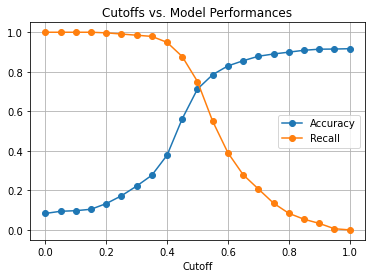

In [105]:
plot_metrics_against_cutoff(model_adaboost)

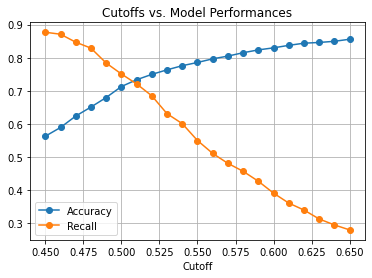

In [106]:
plot_metrics_against_cutoff(
    model_adaboost,
    np.arange(0.45, 0.66, 0.01)
)

In [168]:
cutoff = 0.514

print_model_results(
    "AdaBoost", 
    eval_model(model_adaboost, cutoff), 
    cutoff
)

AdaBoost Results [Cutoff = 0.514] 
Accuracy, Recall = (0.73975, 0.7027027027027027)


In [143]:
cutoff = 0.563

print_model_results(
    "AdaBoost", 
    eval_model(model_adaboost, cutoff), 
    cutoff
)

AdaBoost Results [Cutoff = 0.563] 
Accuracy, Recall = (0.8, 0.4954954954954955)


# Gradient Boosting {-}

In [111]:
start = time.time()

grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.75, 1.0]
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_gradient = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state = 1),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

Total Time (s): 72.72284197807312


In [112]:
grid_search_gradient.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [113]:
model_gradient = GradientBoostingClassifier(
    n_estimators = 200, learning_rate = 0.1,
    max_depth = 3, subsample = 0.5, random_state = 1
).fit(X_train, y_train)

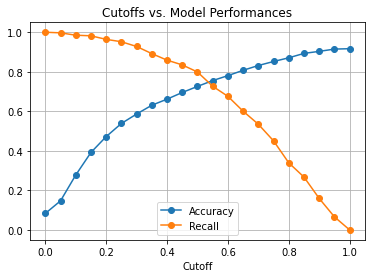

In [114]:
plot_metrics_against_cutoff(model_gradient)

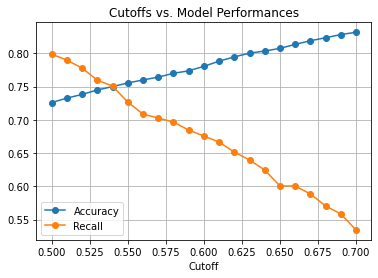

In [115]:
plot_metrics_against_cutoff(
    model_gradient,
    np.arange(0.5, 0.71, 0.01)
)

In [171]:
cutoff = 0.573

print_model_results(
    "Gradient Boosting", 
    eval_model(model_gradient, cutoff), 
    cutoff
)

Gradient Boosting Results [Cutoff = 0.573] 
Accuracy, Recall = (0.7655, 0.7027027027027027)


In [169]:
cutoff = 0.63

print_model_results(
    "Gradient Boosting", 
    eval_model(model_gradient, cutoff), 
    cutoff
)

Gradient Boosting Results [Cutoff = 0.63] 
Accuracy, Recall = (0.80025, 0.6396396396396397)


# Random Forest {-}

In [119]:
start = time.time()

grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': range(10, 35, 5),
    'max_features': range(7, 42, 5)
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 1),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

Total Time (s): 151.59118628501892


In [120]:
grid_search_rf.best_params_

{'max_depth': 25, 'max_features': 7, 'n_estimators': 500}

In [121]:
model_rf = RandomForestClassifier(
    n_estimators = 500, max_depth = 25,
    max_features = 7, random_state = 1
).fit(X_train, y_train)

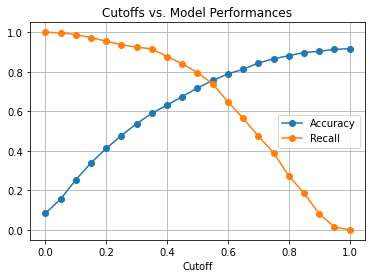

In [122]:
plot_metrics_against_cutoff(model_rf)

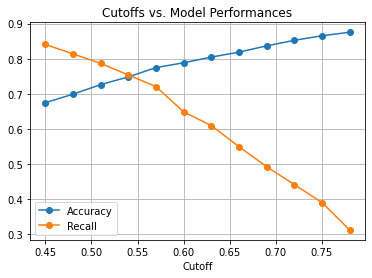

In [123]:
plot_metrics_against_cutoff(
    model_rf,
    np.arange(0.45, 0.8, 0.03)
)

In [173]:
cutoff = 0.576

print_model_results(
    "Random Forest", 
    eval_model(model_rf, cutoff), 
    cutoff
)

Random Forest Results [Cutoff = 0.576] 
Accuracy, Recall = (0.7765, 0.7027027027027027)


In [149]:
cutoff = 0.621

print_model_results(
    "Random Forest", 
    eval_model(model_rf, cutoff), 
    cutoff
)

Random Forest Results [Cutoff = 0.621] 
Accuracy, Recall = (0.8, 0.6156156156156156)


# Extra Trees {-}

In [150]:
start = time.time()

grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': range(10, 35, 5),
    'max_features': range(7, 42, 5),
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
grid_search_et = GridSearchCV(
    estimator = ExtraTreesClassifier(random_state = 1),
    param_grid = grid,
    n_jobs = -1, 
    cv = cv,
    scoring = ['accuracy', 'recall'], 
    refit = 'recall'
).fit(X_train, y_train)

end = time.time()
print("Total Time (s):", end - start)

Total Time (s): 129.12738585472107


In [151]:
grid_search_et.best_params_

{'max_depth': 25, 'max_features': 7, 'n_estimators': 100}

In [153]:
model_et = RandomForestClassifier(
    n_estimators = 100, max_depth = 25,
    max_features = 7, random_state = 1
).fit(X_train, y_train)

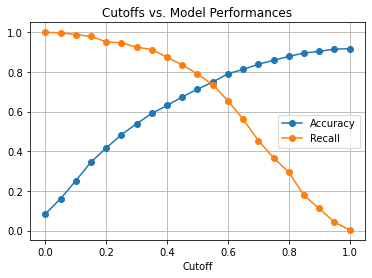

In [154]:
plot_metrics_against_cutoff(model_et)

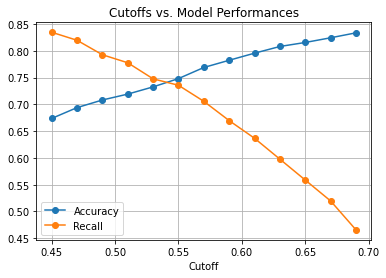

In [155]:
plot_metrics_against_cutoff(
    model_et,
    np.arange(0.45, 0.7, 0.02)
)

In [176]:
cutoff = 0.576

print_model_results(
    "Extra Trees", 
    eval_model(model_et, cutoff), 
    cutoff
)

Extra Trees Results [Cutoff = 0.576] 
Accuracy, Recall = (0.77075, 0.7027027027027027)


In [166]:
cutoff = 0.621

print_model_results(
    "Extra Trees", 
    eval_model(model_et, cutoff), 
    cutoff
)

Extra Trees Results [Cutoff = 0.621] 
Accuracy, Recall = (0.804, 0.6246246246246246)


# Model Performance Comparisons {-}

In [177]:
model_names = [
    'AdaBoost', 'Gradient Boost', 'Random Forest', 'Extra Trees'
]

accuracies = [0.73975, 0.7655, 0.7765, 0.77075]
recalls = [0.495, 0.640, 0.616, 0.625]

pd.DataFrame(
    zip(model_names, accuracies, recalls),
    columns = [
        "Model Name", "Accuracy (at 70% Recall)", "Recall (at 80% Accuracy)"
    ]
)

,Model Name,Accuracy (at 70% Recall),Recall (at 80% Accuracy)
0,AdaBoost,0.73975,0.495
1,Gradient Boost,0.76550,0.640
2,Random Forest,0.77650,0.616
3,Extra Trees,0.77075,0.625


# Final Model Recommendation / Performances {-}

In [ ]:
# TODO (Kind of optional - just tune cutoffs essentially?)

# Feature Importances / Takeaways {-}

In [191]:
features = list(X.columns)
coeffs_gradient = model_gradient.feature_importances_
coeffs_rf = model_rf.feature_importances_
coeffs_et = model_et.feature_importances_

df_coeffs = pd.DataFrame(
    zip(features, coeffs_gradient, coeffs_rf, coeffs_et),
    columns = [
        "Feature", "Coeffs (GB)", "Coeffs (RF)", "Coeffs (ET)"
    ]
)

coeff_cols = df_coeffs.iloc[:, 1:4]
df_coeffs['Avg Coeff'] = coeff_cols.mean(axis = 1)
df_coeff = df_coeffs.sort_values(by = "Avg Coeff", ascending = False)

df_coeff[['Feature', 'Avg Coeff']].iloc[:10,:]

,Feature,Avg Coeff
14,BMI,0.166346
26,PhysicalHealth,0.070652
34,SleepTime,0.065302
18,DiffWalking,0.063990
16,Diabetic_Yes,0.051144
11,AgeCategory_80_or_older,0.044714
32,Sex_Male,0.044449
24,MentalHealth,0.043309
19,GenHealth_Fair,0.031352
9,AgeCategory_70-74,0.028609
